# Regional time series calculations using shapefiles

## Loading libraries

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import os
#intake-esm to load the Pangeo CMIP6 cloud collection
import intake
import regionmask
import cartopy.crs as ccrs

# Accessing CMIP6 data

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
511420,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,sfcWind,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511421,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,Amon,uas,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511422,CMIP,CMCC,CMCC-CM2-HR4,abrupt-4xCO2,r1i1p1f1,day,rlut,gn,gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-HR4/abrupt...,NaN,20210624
511423,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,day,tasmin,gn,gs://cmip6/CMIP6/ScenarioMIP/AS-RCEC/TaiESM1/s...,NaN,20210721


## Checking models available through Pangeo

In [3]:
np.sort(col.df['source_id'].unique())

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-HR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM1-1-CAM5-CMIP5', 'CESM1-WACCM-SC', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM',
       'CMCC-CM2-HR4', 'CMCC-CM2-SR5', 'CMCC-CM2-VHR4', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1', 'E3SM-1-1-ECA',
       'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC', 'EC-Earth3-LR',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'EC-Earth3P', 'EC-Earth3P-HR',
       'EC-Earth3P-VHR', 'ECMWF-IFS-HR', 'ECMWF-IFS-LR', 'FGOALS-f3-H',
       'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-ESM4', 'GFDL-OM4p5B',
       'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'GISS-E2-2-G',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-LM',
       'HadGEM3-GC31-MM', 'IITM-ESM', 'I

In [4]:
#Checking the different runs available within one specific model
col.df.query("source_id == 'ACCESS-ESM1-5'")['member_id'].unique()

array(['r1i1p1f1', 'r3i1p1f1', 'r2i1p1f1', 'r4i1p1f1', 'r6i1p1f1',
       'r9i1p1f1', 'r8i1p1f1', 'r7i1p1f1', 'r5i1p1f1', 'r10i1p1f1',
       'r12i1p1f1', 'r11i1p1f1', 'r13i1p1f1', 'r14i1p1f1', 'r17i1p1f1',
       'r15i1p1f1', 'r16i1p1f1', 'r18i1p1f1', 'r20i1p1f1', 'r19i1p1f1',
       'r30i1p1f1', 'r29i1p1f1', 'r28i1p1f1', 'r24i1p1f1', 'r27i1p1f1',
       'r26i1p1f1', 'r21i1p1f1', 'r25i1p1f1', 'r23i1p1f1', 'r22i1p1f1'],
      dtype=object)

## Accessing sea surface temperature data using ACCESS-ESM 1.5 model
Using one model and one variable initially to develop the script.

In [5]:
# create a subcollection with certain search criteria
cat = col.search(
    #Set the variables that you want to search for
    variable_id = 'tos',
    source_id = 'ACCESS-ESM1-5',
    #Eperiments of interest
    experiment_id = ['historical', 'ssp585'],
    #Native grid
    grid_label = 'gn',
    #Monthly ocean data
    table_id = 'Omon',
    member_id = 'r22i1p1f1'
)


# load all datasets into a python dictionary
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True}, # recommended for faster reading and better time handling
    storage_options={'token': 'anon'}, # needed to access the public CMIP6 data on google
    aggregate=False
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [6]:
SST = ddict['CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r22i1p1f1/Omon/tos/gn/v20200922/.nan.20200922']
SST

<xarray.Dataset>
Dimensions:             (i: 360, j: 300, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
    latitude            (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (time, j, i) float32 dask.array<chunksize=(201, 300, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   175317.0
    cmor_version:            3.4.0
    ...                      ...
    variable_id:             tos
    variant_label:           r22i1p1f1
    version:                 v20200922
    version_id:              v20200922
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.r22i1p1f1.Om...

## Defining function to correct coordinates

In [7]:
def corrcoords(array):
    '''
    Inputs:
    array - Data array on which longitude corrections will be applied.
    
    Output:
    Data array with corrected longitude values.
    '''
    
    #Making a deep copy of original longitude values in the array being corrected
    lon = array['longitude'][0].values
    
    #Values changed from 0-360 to between -180 and +180.
    lon[np.where(lon > 180)] = lon[np.where(lon >180)]-360
    
    #Assigning corrected longitudes and latitude values to i and j, which are index based
    array.coords['i'] = lon
    array.coords['j'] = array['latitude'][:,0].values
    
    #Removing latitude and longitude dimensions and renaming i and j dimensions
    array = array.drop(('latitude', 'longitude'))
    array = array.rename(({'i':'longitude', 'j':'latitude'}))
    
    #Longitude values must be sorted from smallest to largest prior to plotting
    array = array.sortby(array.longitude)
    
    return array

In [8]:
SST_SO = corrcoords(SST.tos).sel(latitude = slice(-90, -30))

/srv/conda/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


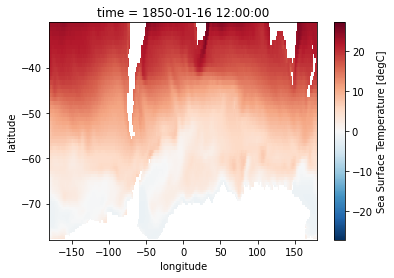

In [9]:
SST_SO[0].plot()

# Loading shapefile with regions of interest
Using `geopandas` to read shapefile and `regionmask` to create the mask to be applied to the dataset.  
For this notebook, a subset of the MEASO regions [https://soki.aq/pages/viewpage.action?pageId=61210912], use to carry out ecosystem assessments in the Southern Ocean, will be used.

<AxesSubplot:>

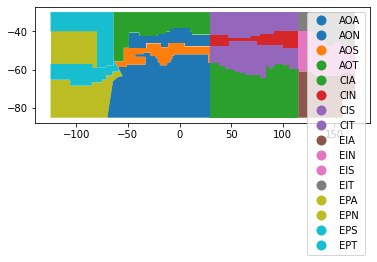

In [10]:
measo = geopandas.read_file('shapefiles/measo_wgs84.shp')

#West Pacific regions are removed because they have duplicate names as the boundaries straddle the -180/180 boundary
measo_sub = measo.query("sector != 'West Pacific'")

#Plotting subset for reference
measo_sub.plot(column = 'name', legend = True)

## Creating an xarray mask of the MEASO regions

In [23]:
#Defining the extent of the shapefile in lat and lon
longitude = SST_SO['longitude'].values
latitude = SST_SO['latitude'].values

#Creating a 3D mask, which includes regions as a dimension
mask3D = regionmask.mask_3D_geopandas(measo_sub, longitude, latitude)
mask3D

mask3D = mask3D.rename({'lon': 'longitude','lat': 'latitude'}).sel(region = 7)

<xarray.DataArray 'region' (region: 16, lat: 77, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... -32.5 -31.5 -30.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * region   (region) int64 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

In [27]:
#Creating a dictionary with region names
names = regionmask.from_geopandas(measo_sub, names = "name", name = "name")

#Creating a new variable with the names of regions
reg = []
[reg.append(names[i].name) for i in mask3D.region.values]

#Replacing numbered regions for names in the mask
mask3D['region'] = reg

#Checking results
mask3D.region

TypeError: iteration over a 0-d array

# Applying masks

In [30]:
#Dhruv's version

#Defining the extent of the shapefile in lat and lon
longitude = SST_SO['longitude'].values
latitude = SST_SO['latitude'].values

#Creating a 3D mask, which includes regions as a dimension
mask3D = regionmask.mask_3D_geopandas(measo_sub, longitude, latitude)

mask3D = mask3D.rename({'lon': 'longitude','lat': 'latitude'})

In [32]:
masked_SST = (mask3D * SST_SO)

/srv/conda/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


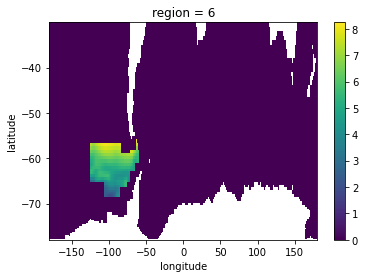

In [38]:
masked_SST.sel(region = 6).sel(time = slice('2000-01-01', '2000-01-31')).mean('time').plot()

In [35]:
for i in masked_SST.region.values:
    masked_SST.plot.sel(region = i)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


# Other things - May be useful

### Selecting data for the Southern Ocean
Calculating mean water temperature per month within the SO (30S to 90S).

In [ ]:
sst_upper200_SO = sst.sel(latitude = slice(-90, -30))
sst_upper200_SO

## Getting horizontal area of grid

In [ ]:
filename = [f[0] for f in zip(df2['filename'][0])]
filepath = os.path.join(df2['path'][0], filename[0])

In [ ]:
area = xr.open_dataarray(filepath, mask_and_scale = True, drop_variables = ("vertices_latitude", "vertices_longitude"))
#Correcting longitude prior to extracting Southern Ocean
area = uf.corrlong(area)
#Extracting Southern Ocean
area = area.sel(latitude = slice(-90, -30))
#Checking data
area.plot()

## Getting thickness (vertical extent) of grid cells

In [ ]:
filename = [f[0] for f in zip(df3['filename'][0])]
filepath = os.path.join(df3['path'][0], filename[0])

In [ ]:
height = xr.open_dataset(filepath, mask_and_scale = True)
#Correcting longitude prior to extracting Southern Ocean
height = uf.corrlong(height)
#Extracting Southern Ocean
height = height.sel(latitude = slice(-90, -30))
#Select only data that is in the upper 200 m - Using lower bound of the depth bins
height = height.thkcello[height.lev_bnds[:,1] <= 200]
#Checking data
height

### Calculating weights from thickness data
Dividing the vertical height of each grid cell by the sum of heights for all grid cells in the upper 200 m.

In [ ]:
sum_heights = height.sum('lev')
weights_vert_levels = height/sum_heights

#Checking data
weights_vert_levels[0].plot()

## Calculating vertically weighted means

In [ ]:
sst_upper200mean_SO = (sst_upper200_SO*weights_vert_levels).sum('lev')

#Applying land mask to the data
sst_upper200mean_SO = sst_upper200mean_SO.where(sum_heights > 0)

#Checking first time step
sst_upper200mean_SO[0].plot(vmin = -2, vmax = 25)

## Loading shapefile with MEASO regions
MEASO regions being used in the analysis were shared by A. Constable on 2021-06-24.

In [ ]:
#Note that the full file path is being used.
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO_shapes_withShelf/MEASO_shapes_withShelf.shp')
regions

### Checking MEASO regions and data are correctly aligned

In [ ]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot just one timestep of the data array
sst_upper200mean_SO[0].plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

In [ ]:
# reg = regions.query('name == "CIS"')
# reg.plot()
fig, ax = plt.subplots(figsize = (5, 20))
sst_upper200mean_SO.rio.clip(reg.geometry, reg.crs, drop = True, invert = False, all_touched = True)[0].plot(ax = ax, add_colorbar = False)
regions.geometry.boundary.plot(ax = ax, color = None, edgecolor = 'black')

## Extracting data per MEASO region

In [ ]:
#Getting names of regions from shapefile
regionNames = sorted(set(regions.name.values))

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in regionNames:
    MEASOregions[f"{i}"] = regions.query(f'name == "{i}"')

In [ ]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_varInt = {}
clipped_area = {}

#Saving each sector as an entry in the dictionary
for i in regionNames:
    clipped_varInt[f"{i}"] = uf.clipDataArray(sst_upper200mean_SO, shp = MEASOregions[i])
    clipped_area[f"{i}"] = uf.clipDataArray(area, shp = MEASOregions[i])

In [ ]:
fig, ax = plt.subplots(figsize = (5, 20))

#Plot just one timestep of the data array
sst_upper200mean_SO.sel(longitude = slice(-80, 30), latitude = slice(-78, -60))[0].plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.geometry.boundary.plot(ax = ax, color = None, edgecolor = 'black')

In [ ]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot just one timestep of the data array
latsSO.plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

### Checking results of extraction

In [ ]:
fig, ax = plt.subplots()
clipped_varInt["CIS"][0].plot(ax = ax, vmin = -1.85, vmax = -1.55)
regions.geometry.boundary.plot(ax = ax, color = None, edgecolor = 'black', alpha = 0.5)

### Calculating weights from horizontal area

In [ ]:
fig, ax = plt.subplots()
sst_upper200mean_SO[0].sel(longitude = slice(30, 120), latitude = slice(-70, -45)).plot(ax = ax, vmin = -1.85, vmax = -1.55)
regions.geometry.boundary.plot(ax = ax, color = None, edgecolor = 'black', alpha = 0.5)

## Calculating weighted means

In [ ]:
#Getting a list of the years included in the data
years = sst_upper200_SO.indexes['time'].year

#Loop through all sectors
for region in regionNames:
    #Slice data per year and calculate seasonal weighted means
    for yr in years:
        x = uf.weightedMeans(clipped_varInt[region].sel(time = str(yr)), clipped_area[region], meanby = 'month')
        #Add time dimension containing the year for which calculations are done
        x = uf.addTimeYear(x, yr, by = 'month')
        #Save netcdf file
        x.to_netcdf('YearlyMonthlyMeans_' + region + 'region_2000-2009.nc')
    #Remove unused variables
    del x

#Remove unused variables
del years

In [ ]:
xr.open_dataarray('YearlyMonthlyMeans_WPNregion_2000-2009.nc')

In [ ]:
x = xr.open_dataset(filepath)
x.attrs